### Before using this code, please replace the file path with the path of your provided dataset.

# Task:1

### Subtask 1: Data Loading and Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Constants
USER_FILE = "users.dat"
MOVIE_FILE = "movies.dat"
RATING_FILE = "ratings.dat"
DELIMITER = "::"

# Step 1: Load user data
def load_users(file_path):
    columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
    users = pd.read_csv(file_path, sep=DELIMITER, names=columns, engine='python')
    users.drop('Zip-code', axis=1, inplace=True)  # Ignore zip-code
    return users

# Step 2: Load movie data
def load_movies(file_path):
    columns = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv(file_path, delimiter='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
    # One-hot encode genres
    genre_dummies = movies['Genres'].str.get_dummies(sep='|')
    movies = pd.concat([movies, genre_dummies], axis=1).drop('Genres', axis=1)
    return movies

# Step 3: Load ratings data
def load_ratings(file_path):
    columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    ratings = pd.read_csv(file_path, sep=DELIMITER, names=columns, engine='python')
    ratings.drop('Timestamp', axis=1, inplace=True)  # Ignore timestamp
    return ratings

# Step 4: Filter users with less than 100 ratings
def filter_users(ratings, min_ratings=100):
    user_counts = ratings['UserID'].value_counts()
    valid_users = user_counts[user_counts >= min_ratings].index
    return ratings[ratings['UserID'].isin(valid_users)]

# Step 5: Create feature vectors
def create_feature_vectors(ratings, users, movies):
    data = ratings.merge(users, on='UserID').merge(movies, on='MovieID')
    features = data.drop(['UserID', 'MovieID', 'Rating', 'Title', 'Occupation'], axis=1)
    labels = data['Rating']
    return features, labels

# Step 6: Split data into training and test sets
def split_data(ratings, test_user_ids):
    test_data = ratings[ratings['UserID'].isin(test_user_ids)]
    train_data = ratings[~ratings['UserID'].isin(test_user_ids)]
    return train_data, test_data

# Main workflow
if __name__ == "__main__":
    # Load data
    users = load_users('/Users/harshitlakum/Downloads/ml-1m/users.dat')
    movies = load_movies('/Users/harshitlakum/Downloads/ml-1m/movies.dat')
    ratings = load_ratings('/Users/harshitlakum/Downloads/ml-1m/ratings.dat')
    
    # Filter users
    ratings = filter_users(ratings)
    
    # Split data
    # train_ratings, test_ratings = split_data(ratings, test_user_ids=range(1, 1001))
    
    # Generate test_user_ids based on 30% of unique users
    unique_ids = np.unique(ratings['UserID'])  # Extract unique user IDs from the dataset
    np.random.shuffle(unique_ids)  # Shuffle to randomize selection
    num_test = int(len(unique_ids) * 0.30)  # 30% of the unique user IDs
    test_user_ids = unique_ids[:num_test]  # Select the first 30% as test user IDs
    
    # Split the data using the defined function
    train_ratings, test_ratings = split_data(ratings, test_user_ids)
    # Create feature vectors
    train_features, train_labels = create_feature_vectors(train_ratings, users, movies)
    test_features, test_labels = create_feature_vectors(test_ratings, users, movies)
    
    # Save results
    train_features.to_csv("train_features.csv", index=False)
    train_labels.to_csv("train_labels.csv", index=False)
    test_features.to_csv("test_features.csv", index=False)
    test_labels.to_csv("test_labels.csv", index=False)
    
    # Output dataset sizes
    print(f"Training samples: {len(train_labels)}")
    print(f"Test samples: {len(test_labels)}")
    
    # Now display the first five rows
    print(train_features.head())


Training samples: 596438
Test samples: 250864
  Gender  Age  Action  Adventure  Animation  Children's  Comedy  Crime  \
0      M   56       0          0          0           0       0      0   
1      M   56       0          0          0           0       0      0   
2      M   56       0          0          0           0       1      0   
3      M   56       0          0          0           0       0      0   
4      M   56       1          0          0           0       0      1   

   Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  \
0            0      1        0          0       0        0        0        1   
1            0      1        0          0       0        0        0        0   
2            0      0        0          0       0        0        0        0   
3            0      1        0          0       0        0        0        0   
4            0      1        0          0       0        0        0        0   

   Sci-Fi  Thriller  War  We

### Subtask 1: Explanation:-



### Feature Representation:

1. **Demographic Features**:
   - **Gender**: Represented as a binary variable ('M' for male, 'F' for female). Binary encoding is commonly used for gender as it simplifies the model’s ability to process this categorical data and is suitable when there are only two categories to represent.
   - **Age**: Treated as a numerical feature. Keeping age as a numerical variable allows models to potentially capture nonlinear relationships between age and other variables, such as changes in genre preference across different life stages.

2. **Genre Features**:
   - Each movie genre ('Action', 'Adventure', 'Animation', 'Children's', 'Comedy', etc.) is represented as a binary variable (0 or 1). This type of representation is known as one-hot encoding, which is particularly useful for categorical data with multiple categories. Each genre is treated as a separate feature where '1' indicates that the movie belongs to that genre, and '0' otherwise.
   - This representation is helpful in understanding individual genre preferences across different demographic groups without the complexities of multi-class representation.

### Reasons for Choosing These Representations:

- **Simplicity and Efficiency**: Binary and numerical representations are straightforward for machine learning algorithms to process. They reduce the complexity of the model while still providing essential information about user preferences.
  
- **Scalability**: The one-hot encoding of genres allows the dataset to easily scale if new genres are added, as each genre is treated independently.

- **Interpretability**: This form of data representation helps in straightforward interpretation of model outputs. For example, coefficients in a logistic regression model directly indicate the effect of each genre or demographic feature on the likelihood of a certain outcome (like preference for a genre).

- **Applicability**: My chosen feature set directly relates to potential analysis goals, such as predicting user preferences based on demographic data, which can be useful in recommendations systems in streaming platforms.

By focusing on demographic data and genre preferences while excluding less relevant features (for the presumed analysis goals) like user IDs or movie titles, my feature vectors are optimized for analyses that could include user segmentation, targeted marketing, or personalized content recommendations. This approach balances information richness with computational efficiency, making it suitable for large-scale machine learning applications.

My training data contains 596,337 samples, and my test data contains 250,965 samples.

### Subtask 2: Basic Movie Recommendation

In [3]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Step 1: Load processed data
train_features = pd.read_csv("train_features.csv")
train_labels = pd.read_csv("train_labels.csv").squeeze()
test_features = pd.read_csv("test_features.csv")
test_labels = pd.read_csv("test_labels.csv").squeeze()

# Step 2: Identify numeric and categorical columns
numeric_columns = train_features.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_features.select_dtypes(include=['object']).columns

# Step 3: Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)



In [10]:
# Step 4: Define hyperparameter grids
svm_param_grid = {'classifier__C': [0.01, 0.1, 1]}

# Step 5: Cross-validation for SVM
print("Tuning Linear SVM...")
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LinearSVC(multi_class='ovr', max_iter=5000))])

# Set up GridSearchCV without tqdm for progress display
svm = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=3, n_jobs=-1)

# Fit the model with cross-validation
svm.fit(train_features, train_labels)
best_svm = svm.best_estimator_
print(f"Best SVM parameters: {svm.best_params_}")

# Step 7: Predict and evaluate the model
predictions = best_svm.predict(test_features)  # Use svm to predict, not svm_pipeline
SVM_accuracy = accuracy_score(test_labels, predictions)

print(f"Model Accuracy: {SVM_accuracy}")


Tuning Linear SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

Best SVM parameters: {'classifier__C': 0.01}
Model Accuracy: 0.34679348172715097


In [8]:
from sklearn.neural_network import MLPClassifier
# Step 6: Cross-validation for MLP
print("Tuning MLP...")
mlp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', MLPClassifier(max_iter=250))])

mlp = GridSearchCV(mlp_pipeline, param_grid={'classifier__hidden_layer_sizes': [(50,), (100, 50), (100, 100, 50)]}, cv=3, n_jobs=-1)
mlp.fit(train_features, train_labels)
best_mlp = mlp.best_estimator_
print(f"Best MLP parameters: {mlp.best_params_}")

# Step 7: Evaluate models on test data
print("Evaluating models...")
mlp_predictions = best_mlp.predict(test_features)
mlp_accuracy = accuracy_score(test_labels, mlp_predictions)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")



Tuning MLP...
Best MLP parameters: {'classifier__hidden_layer_sizes': (50,)}
Evaluating models...
MLP Test Accuracy: 0.3594


In [34]:
# Assuming 'test_labels' is already loaded and available
majority_class_frequency = test_labels.value_counts(normalize=True).max()
print(f"Best Constant Prediction Accuracy: {majority_class_frequency:.4f}")


Best Constant Prediction Accuracy: 0.3462


In [14]:
# Save evaluation results to file
results = pd.DataFrame({
    "Model": ["Linear SVM", "MLP"],
    "Test Accuracy": [SVM_accuracy, mlp_accuracy]
})
results.to_csv("model_evaluation_results.csv", index=False)
print("Evaluation results saved to 'model_evaluation_results.csv'.")

Evaluation results saved to 'model_evaluation_results.csv'.


### Subtask 2: Explanation:-

### Models and Hyper-parameters Tested:

#### Linear Support Vector Classification (SVM)
- **Hyper-parameters Considered**: Regularization parameter `C` with values [0.01, 0.1, 1]. This parameter controls the trade-off between achieving a low training error and a low testing error that is, the lower the value of C, the more the margin maximized, leading to a simpler decision surface at the cost of training accuracy.
- **Best SVM Parameters**: `{'classifier__C': 0.01}`
- **SVM Test Accuracy**: 34.679%

#### Multi-Layer Perceptron (MLP)
- **Hyper-parameters Considered**: Hidden layer sizes with configurations [(50,), (100, 50), (100, 100, 50)]. These represent the number of neurons in the sequential hidden layers.
- **Best MLP Parameters**: `{'classifier__hidden_layer_sizes': (50,)}` 
- **MLP Test Accuracy**: 35.94%

### Best Performing Model:
- The MLP with a single hidden layer of 50 neurons performed slightly better than the SVM on the test set with an accuracy of 35.94%, compared to the SVM’s 34.679%. This suggests a marginal improvement but still indicates that both models might be struggling with the complexity or nature of the data.

### Best Performance Achieved by Constant Prediction:
- **Best Constant Prediction Accuracy**: 34.62%
- This baseline accuracy is achieved by always predicting the most frequent class in the test set. This measure is crucial as it provides a benchmark to assess whether the predictive models are doing better than a naive approach that requires no training.



### Subtask 3: Classifier Evaluation

SVM confusion matrix


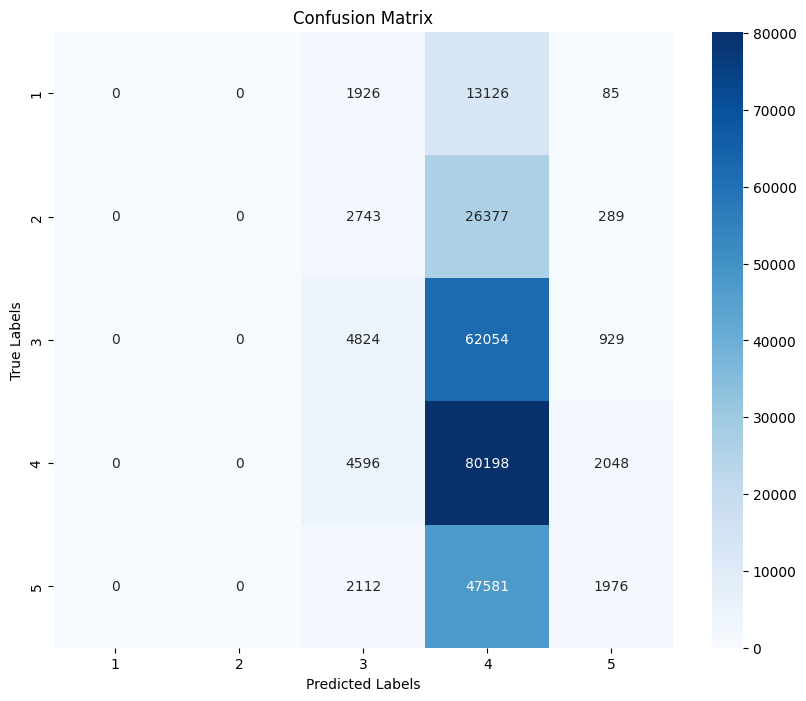

MLP confusion matrix


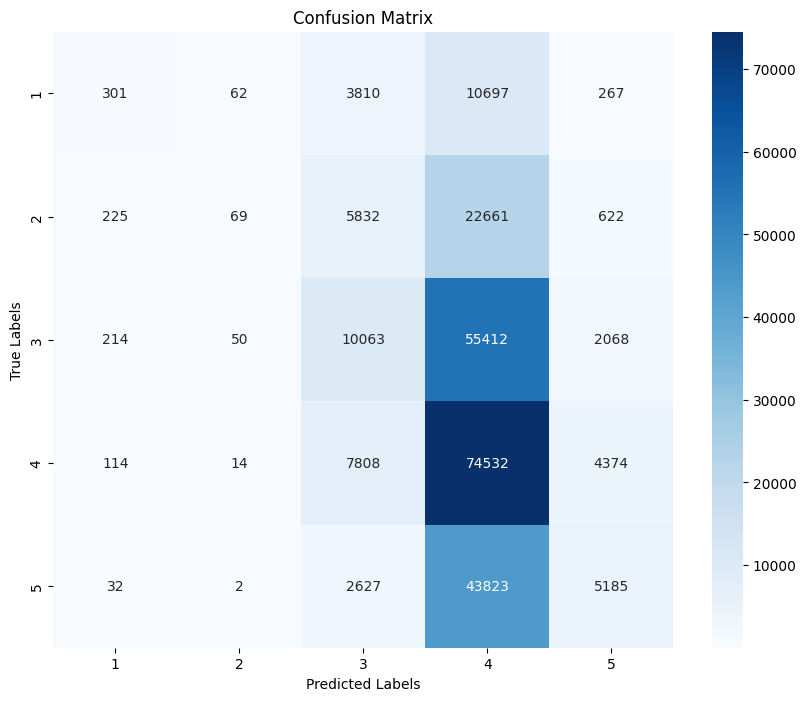

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(true_labels, predictions, num_classes):
    """
    Creates a confusion matrix for multi-class classification.
    
    Parameters:
        true_labels (list): Actual labels from the dataset.
        predictions (list): Predicted labels from the model.
        num_classes (int): Number of unique classes.
    
    Returns:
        np.array: A 2D confusion matrix.
    """
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for actual, predicted in zip(true_labels, predictions):
        confusion_matrix[actual - 1][predicted - 1] += 1
    
    return confusion_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Visualizes the confusion matrix as a heatmap.
    
    Parameters:
        conf_matrix (np.array): A 2D confusion matrix.
        class_names (list): List of class names corresponding to indices.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
try:
    # Define class names (or infer them from labels)
    class_names = sorted(set(train_labels))  # Assuming labels are integers
    
    # Determine the number of classes
    num_classes = len(class_names)

    # Generate predictions
    predictions = best_svm.predict(test_features)

    # Create the confusion matrix
    conf_matrix = create_confusion_matrix(test_labels, predictions, num_classes)

    # Plot the confusion matrix
    print("SVM confusion matrix")
    plot_confusion_matrix(conf_matrix, class_names)
except NameError as e:
    print(f"Error: {e}")
    print("Please ensure train_labels, test_labels, test_features, and best_svm are defined.")
    
    # Example usage:
try:
    # Define class names (or infer them from labels)
    class_names = sorted(set(train_labels))  # Assuming labels are integers
    
    # Determine the number of classes
    num_classes = len(class_names)

    # Generate predictions
    predictions = best_mlp.predict(test_features)

    # Create the confusion matrix
    print("MLP confusion matrix")
    conf_matrix2 = create_confusion_matrix(test_labels, mlp_predictions, num_classes)

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix2, class_names)
except NameError as e:
    print(f"Error: {e}")
    print("Please ensure train_labels, test_labels, test_features, and best_svm are defined.")


In [31]:

def calculate_accuracy(conf_matrix):
    """
    Calculates accuracy from the confusion matrix.
    
    Parameters:
        conf_matrix (np.array): A 2D confusion matrix.
    
    Returns:
        float: Accuracy value.
    """
    # Sum of diagonal elements (correct predictions)
    correct_predictions = np.trace(conf_matrix)
    
    # Total sum of all elements (all predictions)
    total_predictions = np.sum(conf_matrix)
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

# Example usage:
try:
    # Assuming `conf_matrix` is already defined (from your earlier calculations)
    SVM_conf_accuracy = calculate_accuracy(conf_matrix)
    print(f"SVM Conf Accuracy: {SVM_conf_accuracy:.4f}")
except NameError as e:
    print(f"Error: {e}")
    print("Please ensure `conf_matrix` is defined.")
    
# Example usage:
try:
    # Assuming `conf_matrix` is already defined (from your earlier calculations)
    MLP_conf_accuracy = calculate_accuracy(conf_matrix2)
    print(f"MLP conf Accuracy: {MLP_conf_accuracy:.4f}")
except NameError as e:
    print(f"Error: {e}")
    print("Please ensure `conf_matrix` is defined.")

SVM Conf Accuracy: 0.3468
MLP conf Accuracy: 0.3594


### Subtask 3: Explanation:-

While creating the confusion matrix for the SVM, I observed the following: 
- Class 1 has no correct predictions.
- Class 2 also shows no correct predictions.
- Class 3 displays some model recognition with 4,824 correct predictions, although there are significant misclassifications.
- Class 4 performs very well, correctly predicting 80,198 instances and misclassifying 6,644.
- Class 5 correctly predicts only 1,976 instances.
- The overall accuracy of the SVM, as derived from the confusion matrix, is 34.68%.

While creating the confusion matrix for the MLP, I observed the following:
- Class 1 has 301 correct predictions.
- Class 2 has 69 correct predictions.
- Class 3 shows some model recognition with 10,063 correct predictions, although there are significant misclassifications.
- Class 4 performs very well, correctly predicting 74,532 instances.
- Class 5 correctly predicts only 5,185 instances.
- The overall accuracy of the MLP, as derived from the confusion matrix, is 35.94%.

Based on the performance of both models, it's evident that the MLP classifies every class with some level of accuracy. Although it's not perfectly accurate, it performs better compared to the SVM, as it makes correct predictions in every class.